In [1]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [2]:
# Experiment setup
experiment_name1 = '1801'
experiment_name2 = '1901'
data_dir1 = f'./data/{experiment_name1}'
data_dir2 = f'./data/{experiment_name2}'
exp1 = decode_eeg.Experiment(experiment_name1,data_dir1)
exp2 = decode_eeg.Experiment(experiment_name2,data_dir2)

In [3]:
# Classification parameters and setup
time_window = 50
time_step = 25
trial_average = 20
n_splits = 1000
group_dict_list =  [{0:[1],1:[2]},{0:[2],1:[3]},{0:[3],1:[4]}]
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict_list=group_dict_list)

sync = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1,experiment_name2])

clfr = decode_eeg.Classification(wrangl,sync.nsub,num_labels=2)

In [4]:
# If you want to retrain classifiers, run this cell. Otherwise run next cell.
clfr.acc = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.acc_shuff = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.conf_mat = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits,clfr.num_labels,clfr.num_labels))*np.nan

for isub,sub in enumerate(sync.matched_ids):
    print(isub)
    xdata_all,ydata_all = sync.load_eeg(sub)
    
    for xdata,ydata in sync.pairwise(xdata_all,ydata_all):
        xdata,ydata = sync.balance_labels(xdata,ydata)
        xdata,ydata = sync.average_trials(xdata,ydata)
        xdata,ydata = sync.group_data(xdata,ydata) # check if this is correct or should be group labels?
        for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
            X_test_all, y_test = wrangl.balance_labels(X_test_all,y_test)
            y_test_shuffle = np.random.permutation(y_test)
            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                    clfr.decode_pairwise(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

# Set up interp object and save results.
interp = decode_eeg.Interpreter(clfr,subtitle=f'single_feature_pairwise_ss_trialbin{trial_average}_')
interp.save_results()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [5]:
interp = decode_eeg.Interpreter()
interp.load_results('single_feature_pairwise_ss_trialbin20.pickle')

1 vs 2 significant timepoints: [ 184  208  232  256  280  304  328  352  376  400  424  448  472  496
  520  544  568  592  616  640  664  688  712  736  760  784  808  832
  856  880  904  928  952  976 1000 1024 1048 1072 1096 1120 1144 1168
 1192]
1 vs 2 mean delay accuracy: 0.6423952690972222
1 vs 2 mean delay S.D.: 0.05027486928398518
2 vs 3 significant timepoints: [ 184  208  232  256  280  304  328  352  376  400  424  448  472  496
  520  544  568  592  616  640  664  688  712  736  760  784  808  832
  856  880  904  928  952  976 1000 1024 1048 1072 1096 1120 1144 1168
 1192]
2 vs 3 mean delay accuracy: 0.6086982638888889
2 vs 3 mean delay S.D.: 0.0300556269404045
3 vs 4 significant timepoints: [ 184  208  232  256  280  304  328  352  376  400  424  448  472  496
  520  544  568  592  616  640  664  688  712  736  760  808  832  856
  880  904  928  952 1024 1120 1144 1192]
3 vs 4 mean delay accuracy: 0.5501578125
3 vs 4 mean delay S.D.: 0.021650651107053925
Saving output\fi

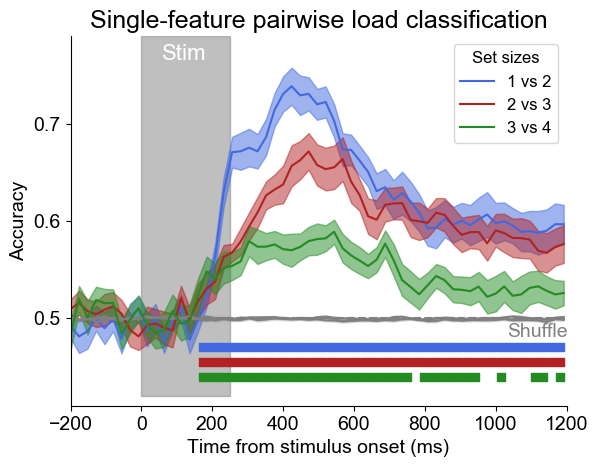

In [8]:
interp.plot_acc_subset(
    subset_list=['1 vs 2','2 vs 3','3 vs 4'],
    ylim=[.41,.79], 
    chance=.5, 
    sig_ys=[.47,.455,.44],
    chance_text_y=.225,
    significance_testing=True,
    title='Single-feature pairwise load classification',
    subtitle = '_single_feat_ss',
    legend_title='Set sizes',
    savefig=True)